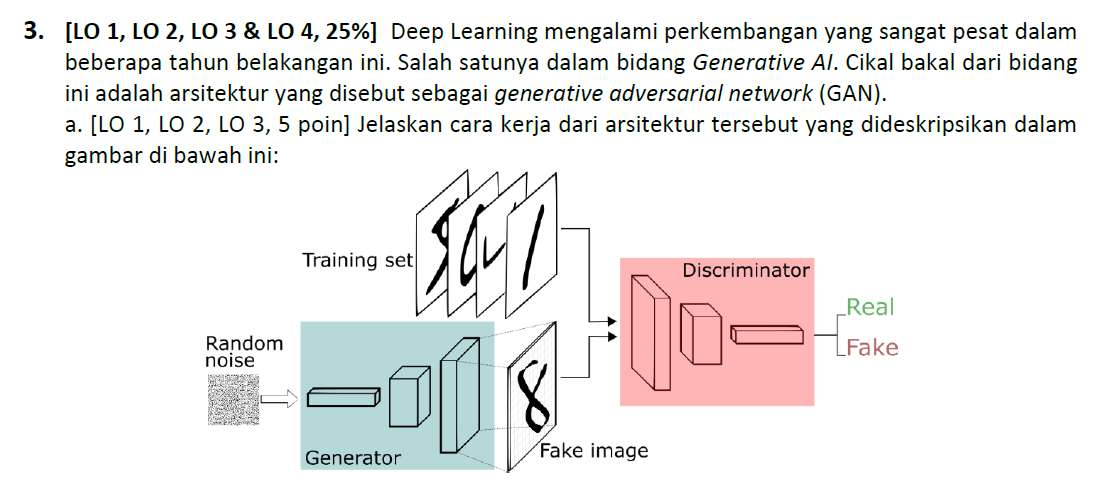

3. a. Gambar yang ditampilkan menunjukan diagram arsitektur Generative Adversarial Networks (GAN) yang terdiri dari beberapa komponen utama yang disebutkan pada gambar : 
Generator
= jaringan saraf yang akan menghasikan gambar palsu yang mirip dengan gambar asli dari training set di atas
Discriminator
= jaringan saraf yang bertugas sebagai “polisi/penjaga”, yang dimana bertugas membedakan antara mana gambar yang asli dan gambar yang palsu dari gambar yang dihasilkan oleh generator
Random Noise
= random vector yang akan digunakna sebagai input dari generator yang berfungsi sebagai seed untuk menghasilkan gambar
Training set 
= kumpulan data gambar asli yang akan digunakan untuk referensi dalam melatih model GAN

	Proses pelatihan GAN bersifat kompetitif, dimana Generator dan Discriminator saling bersaing untuk meningkatkan kemampuan masing-masing. Generator berusaha menghasilkan data baru yang realitstis (gambar, video, dan audio) yang mirip dengan data asli, sementara discriminator bertugas membedakan antara data asli, sementara Discriminator bertugas mebedakan antara data asli dan data palsu. Meskipun GAN memiliki potensi besar dalam menghasilkan data yang realistis, ada beberapa keterbatasan. Proses pelatihan GAN bisa sangat sulit dan kompleks, serta kadang menghasilkan gambar yang tidak konsisten. Namun jika ingin dijabarkan, sebenarnya proses pelatihan GAN hanya melibatkan 2 langkah yang diulang-ulang. Pertama generator menghasilkan data baru dengan menerima vektor acak sebagai input dan menghasilkan data baru. Kedua Discriminator membedakan antara data aslid an data yang dihasilkan Generator dan mencoba untuk membedakan antara keduanya.
	Salah satu contoh implementasinya adalah ketika proses deteksi uang menggunakan GAN. GAN diharapkan dapat membedakan dengan akurat antara uang asli dan uang palsu. Discriminator harus mampu mengenali ciri-ciri uang asli dan mendeteksi pola-pola uang palsu yang dihasilkan oleh Generator. Discriminator yang mampu dengan sangat baik membedakan antara uang asli dan palsu. Ini berarti bahwa Discriminator harus dilatih sampai dapat dengan mudah mengenali ciri-ciri unik dari uang asli dan mendeteksi uang palsu yang dihasilkan oleh Generator. Pada awal pelatihan, Generator loss mungkin tinggi karena Generator belum mampu menghasilkan gambar yang realistis. Seiring pelatihan, Generator loss diharapkan menurun karena Generator mulai menghasilkan gambar yang lebih realistis yang sulit dibedakan oleh Discriminator. Idealnya, dalam pelatihan GAN yang sukses, loss Generator dan loss Discriminator akan mendekati titik keseimbangan, di mana keduanya memiliki performa yang seimbang.


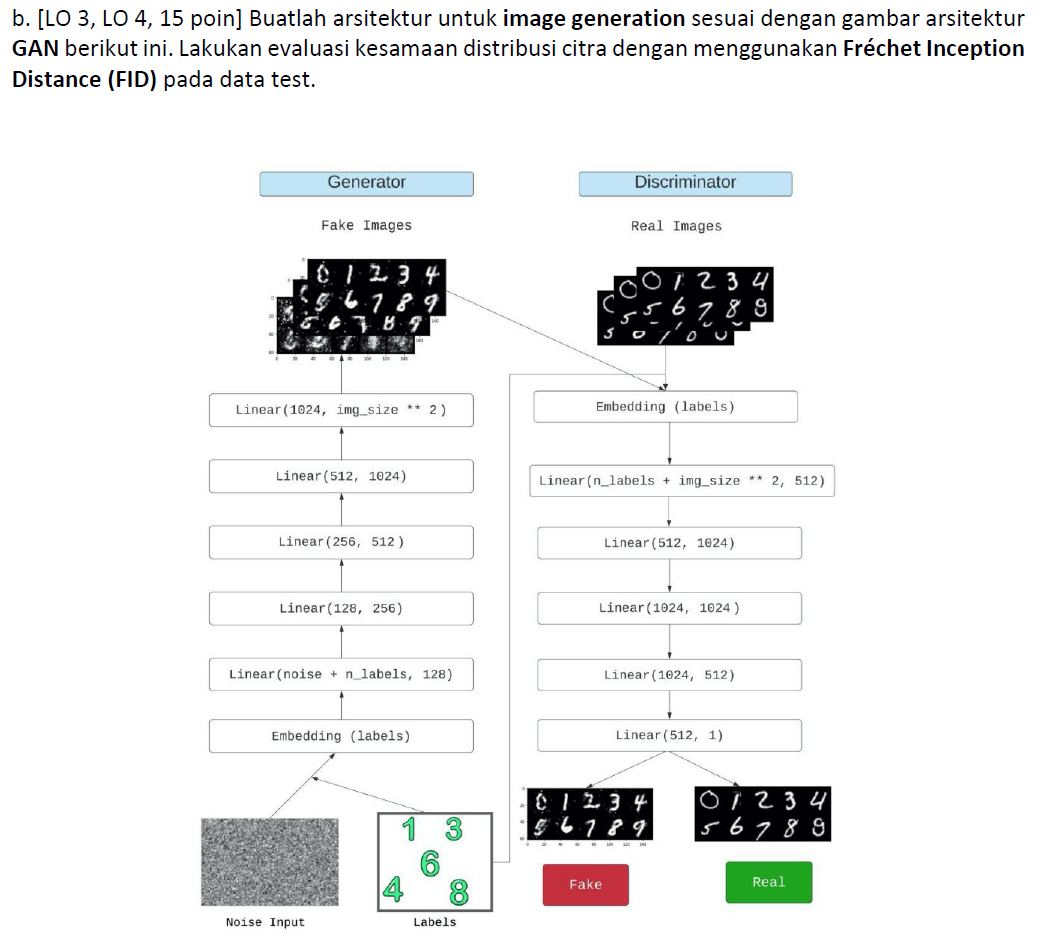

In [1]:
# basic library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os
import requests
import gzip
import urllib.request
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from collections import Counter
from tqdm import tqdm_notebook
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
%matplotlib inline
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Embedding, multiply, Dropout, BatchNormalization, Activation, UpSampling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from scipy.linalg import sqrtm
from numpy import cov, trace, iscomplexobj

2024-07-07 19:16:29.169074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 19:16:29.169123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 19:16:29.170550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


EXPLORE + SPLITTING DATA (dari 2a)

In [3]:
# direktori data full
dir_folder = 'dataset_nomor2-3'

In [4]:
# buat direktori jika belum ada
os.makedirs(dir_folder, exist_ok=True)

In [5]:
# file yang mau di download
files = {
    "train-images-idx3-ubyte.gz": "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz": "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz",
    "t10k-images-idx3-ubyte.gz": "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz": "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"
}

In [6]:
# function untuk download file
def download_file(url, dest):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(dest, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"File downloaded: {dest}")
    else:
        print(f"Failed to download file from {url}")

In [7]:
# download semua file
for filename, url in files.items():
    dest_path = os.path.join(dir_folder, filename)
    download_file(url, dest_path)

File downloaded: dataset_nomor2-3/train-images-idx3-ubyte.gz
File downloaded: dataset_nomor2-3/train-labels-idx1-ubyte.gz
File downloaded: dataset_nomor2-3/t10k-images-idx3-ubyte.gz
File downloaded: dataset_nomor2-3/t10k-labels-idx1-ubyte.gz


In [8]:
# function untuk load data
def load_data():
    x_train_path = os.path.join(dir_folder, 'train-images-idx3-ubyte.gz')
    y_train_path = os.path.join(dir_folder, 'train-labels-idx1-ubyte.gz')
    x_test_path = os.path.join(dir_folder, 't10k-images-idx3-ubyte.gz')
    y_test_path = os.path.join(dir_folder, 't10k-labels-idx1-ubyte.gz')
    
    with gzip.open(x_train_path, 'rb') as f:
        x_train = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 28, 28)
    
    with gzip.open(y_train_path, 'rb') as f:
        y_train = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    
    with gzip.open(x_test_path, 'rb') as f:
        x_test = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 28, 28)
    
    with gzip.open(y_test_path, 'rb') as f:
        y_test = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    
    return (x_train, y_train), (x_test, y_test)

In [9]:
# function untuk scaling data
def scale_data(x_train, x_test):
    x_train_scaled = x_train.astype('float32') / 255.
    x_test_scaled = x_test.astype('float32') / 255.
    return x_train_scaled, x_test_scaled

LOAD DATA

In [10]:
(x_train, y_train), (x_test, y_test) = load_data()

SCALING DATA

In [11]:
x_train_scaled, x_test_scaled = scale_data(x_train, x_test)

FILTER HANYA AMBIL LABEL PULLOVER (2) DAN DRESS (3)

In [12]:
pullover_dress_filter = (y_train == 2) | (y_train == 3)
x_train_filtered = x_train_scaled[pullover_dress_filter]
y_train_filtered = y_train[pullover_dress_filter]

pullover_dress_filter_test = (y_test == 2) | (y_test == 3)
x_test_filtered = x_test_scaled[pullover_dress_filter_test]
y_test_filtered = y_test[pullover_dress_filter_test]

SPLITTING 80% TRAINING, 10% VALIDATION, 10% TEST

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train_filtered, y_train_filtered, test_size=0.2, random_state=42)

# gunakan data test yang telah difilter
x_test = x_test_filtered
y_test = y_test_filtered

In [14]:
num_train_samples = x_train.shape[0]
num_val_samples = x_val.shape[0]
num_test_samples = x_test.shape[0]
num_classes = len(np.unique(y_train))

print(f"Jumlah data training: {num_train_samples}")
print(f"Jumlah data validation: {num_val_samples}")
print(f"Jumlah data testing: {num_test_samples}")
print(f"Jumlah kelas: {num_classes}")

Jumlah data training: 9600
Jumlah data validation: 2400
Jumlah data testing: 2000
Jumlah kelas: 2


MENDEFINISIKAN KELAS (untuk kemudahan saya saja)

In [15]:
class_names = {
    2: "Pullover",
    3: "Dress"
}

In [16]:
def show_and_validate_labels(labels, class_names):
    unique_labels = np.unique(labels)
    print("Label yang ada dalam dataset:")
    for label in unique_labels:
        if label in class_names:
            print(f"Label {label}: {class_names[label]}")
        else:
            print(f"Label {label} tidak ada dalam deskripsi kelas!")

In [17]:
show_and_validate_labels(y_train, class_names)

Label yang ada dalam dataset:
Label 2: Pullover
Label 3: Dress


SHOW IMAGE

In [18]:
def show_images_per_class(images, labels, class_names):
    plt.figure(figsize=(10, 5))
    unique_labels = np.unique(labels)
    for i, label in enumerate(unique_labels):
        index = np.where(labels == label)[0][0]
        plt.subplot(1, 2, i + 1)
        plt.imshow(images[index], cmap='gray')
        plt.title(f'{class_names[label]} ({label})')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

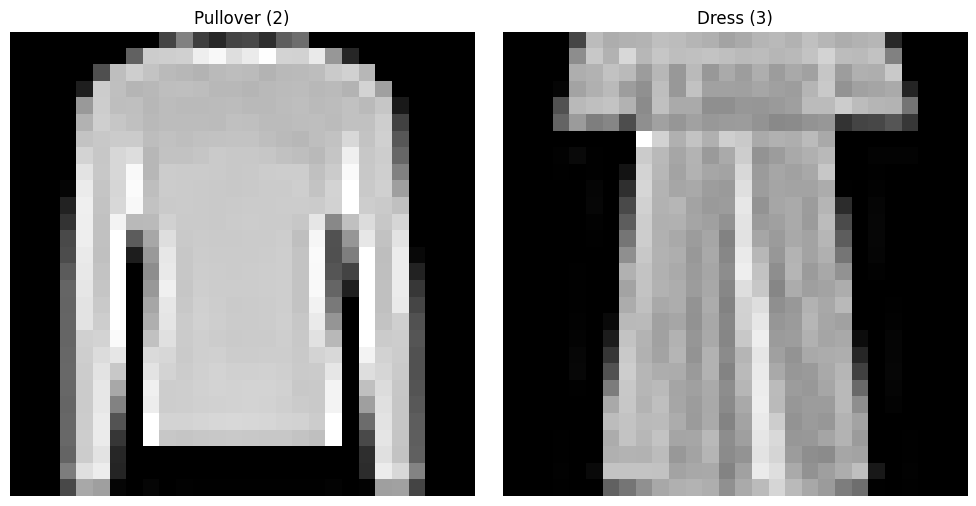

In [19]:
show_images_per_class(x_train, y_train, class_names)

MELIHAT DIMENSI DAN BENTUK DATA

In [20]:
print(f"Bentuk data training: {x_train.shape}")
print(f"Bentuk data validation: {x_val.shape}")
print(f"Bentuk data testing: {x_test.shape}")

Bentuk data training: (9600, 28, 28)
Bentuk data validation: (2400, 28, 28)
Bentuk data testing: (2000, 28, 28)


MELIHAT DISTRIBUSI DATA

In [21]:
def show_data_distribution(labels, title):
    label_counts = Counter(labels)
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah')
    plt.title(title)
    plt.xticks(list(class_names.keys()), list(class_names.values()), rotation=45)
    plt.show()

Distribusi data training:


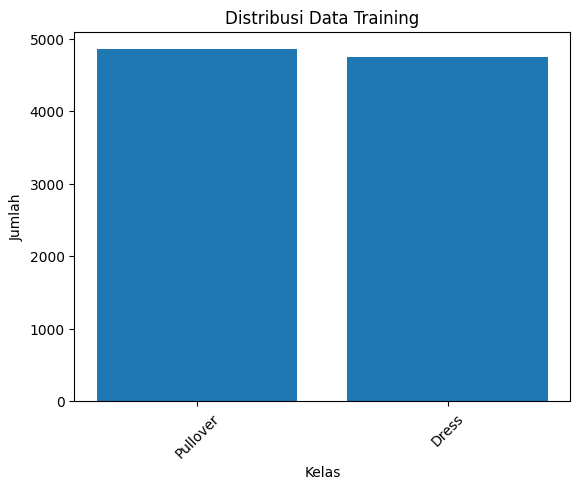

In [22]:
print("Distribusi data training:")
show_data_distribution(y_train, "Distribusi Data Training")

Distribusi data validation:


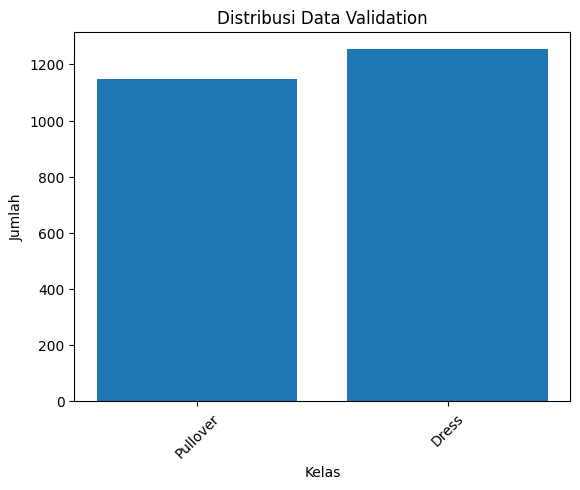

In [23]:
print("Distribusi data validation:")
show_data_distribution(y_val, "Distribusi Data Validation")

Distribusi data testing:


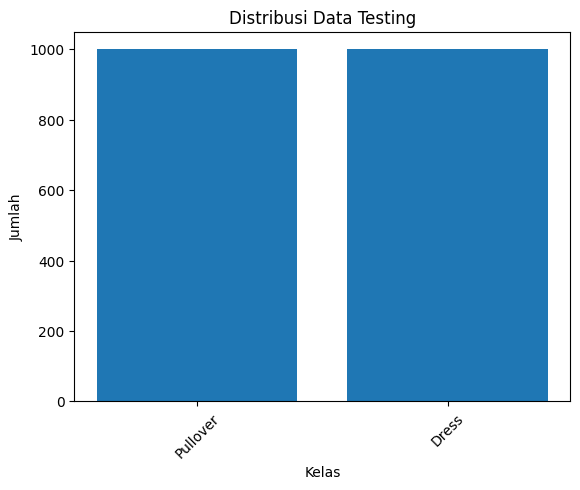

In [24]:
print("Distribusi data testing:")
show_data_distribution(y_test, "Distribusi Data Testing")

In [25]:
# distribusi data training
train_distribution = Counter(y_train)
print("Distribusi data training:")
print(train_distribution)

# distribusi data validation
val_distribution = Counter(y_val)
print("\nDistribusi data validation:")
print(val_distribution)

# distribusi data testing
test_distribution = Counter(y_test)
print("\nDistribusi data testing:")
print(test_distribution)

Distribusi data training:
Counter({2: 4853, 3: 4747})

Distribusi data validation:
Counter({3: 1253, 2: 1147})

Distribusi data testing:
Counter({2: 1000, 3: 1000})


MODEL GAN

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [26]:
# pip install pytorch-fid

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np
import os
import requests
import gzip
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm
from pytorch_fid import fid_score

In [28]:
# Hyperparameters
img_size = 28
num_classes = 10
noise_dim = 100
batch_size = 64
n_epochs = 100
sample_interval = 200

In [29]:
# Load datasets (assuming x_train, y_train, x_val, y_val are already loaded)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
x_test_tensor = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [30]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, img_size ** 2),
            nn.Tanh()
        )
    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), 1, img_size, img_size)
        return img

In [31]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(img_size ** 2 + num_classes, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)
        validity = self.model(d_in)
        return validity

In [32]:
# Initialize models, loss function, and optimizers
generator = Generator()
discriminator = Discriminator()
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.00005, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999))

In [33]:
# Train the models
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)

        valid = torch.ones((batch_size, 1), dtype=torch.float, requires_grad=False)
        fake = torch.zeros((batch_size, 1), dtype=torch.float, requires_grad=False)

        real_imgs = imgs
        labels = labels

        optimizer_G.zero_grad()

        z = torch.randn((batch_size, noise_dim))
        gen_labels = torch.randint(0, num_classes, (batch_size,))

        gen_imgs = generator(z, gen_labels)

        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)
   
        d_loss = (d_real_loss + d_fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()

        real_preds = validity_real > 0.5
        fake_preds = validity_fake < 0.5
        d_accuracy = torch.mean(torch.cat((real_preds, fake_preds), 0).float())

        g_accuracy = torch.mean((validity > 0.5).float())
        
        # Print progress
        if i % sample_interval == 0:
            print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.6f}, acc: {d_accuracy.item():.6f}] [G loss: {g_loss.item():.6f}, acc: {g_accuracy.item():.6f}]")


[Epoch 0/100] [Batch 0/150] [D loss: 0.693847, acc: 0.500000] [G loss: 0.683214, acc: 1.000000]
[Epoch 1/100] [Batch 0/150] [D loss: 0.136882, acc: 0.976562] [G loss: 2.542136, acc: 0.031250]
[Epoch 2/100] [Batch 0/150] [D loss: 0.225275, acc: 0.835938] [G loss: 3.605056, acc: 0.250000]
[Epoch 3/100] [Batch 0/150] [D loss: 0.061458, acc: 1.000000] [G loss: 3.708003, acc: 0.000000]
[Epoch 4/100] [Batch 0/150] [D loss: 0.281022, acc: 0.828125] [G loss: 3.737619, acc: 0.312500]
[Epoch 5/100] [Batch 0/150] [D loss: 0.203413, acc: 0.898438] [G loss: 4.278480, acc: 0.140625]
[Epoch 6/100] [Batch 0/150] [D loss: 0.122499, acc: 0.960938] [G loss: 4.386105, acc: 0.000000]
[Epoch 7/100] [Batch 0/150] [D loss: 0.156677, acc: 0.945312] [G loss: 3.929627, acc: 0.062500]
[Epoch 8/100] [Batch 0/150] [D loss: 0.087246, acc: 0.945312] [G loss: 4.088995, acc: 0.062500]
[Epoch 9/100] [Batch 0/150] [D loss: 0.197100, acc: 0.937500] [G loss: 6.320925, acc: 0.000000]
[Epoch 10/100] [Batch 0/150] [D loss: 0.

In [34]:
# Generate and save images
generated_images_path = "generated_images"
os.makedirs(generated_images_path, exist_ok=True)
def save_images(generator, num_images, noise_dim, num_classes, img_size, path):
    for i in range(num_images):
        z = torch.randn((1, noise_dim))
        gen_labels = torch.randint(0, num_classes, (1,))
        gen_imgs = generator(z, gen_labels)
        img = transforms.ToPILImage()(gen_imgs[0].cpu())
        img.save(os.path.join(path, f"gen_img_{i}.png"))

save_images(generator, 2000, noise_dim, num_classes, img_size, generated_images_path)

real_images_path = 'dataset_nomor2-3'

In [35]:
# Ensure the directory exists
os.makedirs(real_images_path, exist_ok=True)

In [37]:
from PIL import Image
# Function to save real images with specific labels
def save_filtered_real_images(images, labels, path, class_names):
    # Filter the images based on the specified labels (Pullover and Dress)
    filter_mask = np.isin(labels, list(class_names.keys()))
    filtered_images = images[filter_mask]
    filtered_labels = labels[filter_mask]

    # Save the filtered images to the specified directory
    for i in range(filtered_images.shape[0]):
        img = Image.fromarray((filtered_images[i] * 255).astype(np.uint8))  # Convert back to [0, 255] range
        img.save(os.path.join(path, f"real_img_{i}_label_{filtered_labels[i]}.png"))
# Save the filtered real images from the test dataset
save_filtered_real_images(x_test, y_test, real_images_path, class_names)

In [40]:
def save_real_images(real_images, path):
    os.makedirs(path, exist_ok=True)
    for i in range(real_images.size(0)):
        img = transforms.ToPILImage()(real_images[i].cpu())
        img.save(os.path.join(path, f"real_img_{i}.png"))
# Generate and save images for FID evaluation
fid_evaluation_path_gen = "/kaggle/working/generated_images"
fid_evaluation_path_real = "/kaggle/working/dataset_nomor2-3"
num_fid_images = 1000  # Number of images to generate for FID evaluation


In [41]:
# Ensure the directories exist
os.makedirs(fid_evaluation_path_gen, exist_ok=True)
os.makedirs(fid_evaluation_path_real, exist_ok=True)# Generate and save synthetic images
save_images(generator, num_fid_images, noise_dim, num_classes, img_size, fid_evaluation_path_gen)

# Save real images from the test dataset
save_real_images(x_test_tensor[:num_fid_images], fid_evaluation_path_real)

In [45]:
# Perhitungan FID Score dengan dimensi yang lebih rendah
paths = [fid_evaluation_path_real, fid_evaluation_path_gen]
fid_value = fid_score.calculate_fid_given_paths(paths, batch_size=50, device=device, dims=64)  # atau dims=128
print(f"FID score between real and generated images: {fid_value}")


100%|██████████| 40/40 [00:00<00:00, 46.68it/s]

FID score between real and generated images: 15.544976224134704


Nilai FID score sebesar 15.54 menunjukkan bahwa ada perbedaan yang cukup signifikan antara distribusi citra-citra asli (dari dataset uji) dan citra-citra yang dihasilkan oleh model GAN Anda. Idealnya, Anda ingin mencapai FID score yang lebih rendah, mendekati nol, untuk menunjukkan bahwa citra-citra yang dihasilkan sangat mirip dengan citra-citra asli.

Untuk meningkatkan kualitas citra-citra yang dihasilkan, pertimbangkan untuk melakukan beberapa optimisasi pada model GAN Anda seperti:

Pengaturan hyperparameter, seperti learning rate, jumlah epoch, dan ukuran batch.
Arsitektur model ,mungkin mengubah lapisan-lapisan dalam generator atau diskriminator yang masih tidak sesuai dengan soal.
Penambahan regularisasi, seperti dropout atau batch normalization.